In [1]:
# https://course.fast.ai/videos/?lesson=10&t=3167 @52:46
# Callbacks
# keep track of metrics: progress bar animation
# hyper params scheduling 
# regularization techniques
# tensorboards
# mixed precision training


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pdb import set_trace
from functools import partial
import math
from fastai_tf.fastai.utils.callbacks import Runner, Callback, CancelTrainException, LR_Find, Recorder

# Early Stopping

## Better callback cancellation

In [4]:
mnist = tf.keras.datasets.mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train.min(), y_train.max())
n, m = x_train.shape
c = y_train.max() + 1
print(n, m, c)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000,) (10000, 784) (10000,) 0 9
60000 784 10


In [5]:
def normalize(x, m, s): return (x - m) / s

In [6]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(33.318421449829934, 78.56748998339798)

In [7]:
x_train = normalize(x_train, train_mean, train_std)
x_test  = normalize(x_test,  train_mean, train_std)

In [8]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(-3.064638490070051e-17, 0.9999999999999998)

In [9]:
class Model(tf.keras.Model):
    def __init__(self, nh, n_out):        
        super().__init__()
        self.lrs = [tf.keras.layers.Dense(nh), tf.keras.layers.ReLU(), tf.keras.layers.Dense(n_out)]
        
    def call(self, x):
        for l in self.lrs: x = l(x)
        return x
    
# corss entropy loss
def cross_entropy(targets, predictions):
    return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predictions))

# here the target MUST NOT BE one hot encoded
def accuracy(targets, predictions):
    y_predictions = tf.cast(tf.argmax(predictions, axis=1), dtype=tf.float32)
    y_targets = tf.cast(targets, dtype=tf.float32)
    return tf.math.reduce_mean(tf.cast(tf.math.equal( y_predictions, y_targets) , dtype=tf.float32))

# class cross_entropy():
#     def __init__(self):
#         pass
    
#     def call(self, targets, predictions):
#         return tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(targets, predictions))

    

## Packing Your Full Model into a Learner

In [10]:
# The idea is to pack your model into something that take
# 1. the model 
# 2. the optimization method 
# 3. the loss function amd 4. the data
class Learner():
    def __init__(self, model, optimizer, loss_function, data):
        self.model, self.optimizer, self.loss_function, self.data = model, optimizer, loss_function, data

In [11]:
# The data as well can be packed into a DataBunch containing 
# 1. the training data
# 2. the validation data
# 3. the classes from 0 to 9
# in a future version it can be interesting to get a subsample of the full data
# for training purposes
class DataBunch():
    def __init__(self, train_dl, valid_dl, classes=None):
        self.train_dl, self.valid_dl, self.classes = train_dl, valid_dl, classes
        self.train_samples, self.valid_samples =  len(list(self.train_dl)), len(list(self.valid_dl))            

In [12]:
def one_hot(x, y, classes):
    return x, tf.one_hot(y, classes)

In [13]:
# Setting the dataset in tensorflow

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: one_hot(x, y, classes=c))

valid_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.map(lambda x, y: one_hot(x, y, classes=c))
train_ds, valid_ds

(<MapDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>,
 <MapDataset shapes: ((None, 784), (None, 10)), types: (tf.float64, tf.float32)>)

In [14]:
# Now how to fix this and insert callbacks: metrics and stuff

In [15]:
class LossAcc():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = metrics, in_train
        self.reset()
        
    def reset(self):
        self.tot_loss, self.tot_acc = 0., 0.
        
    def calculate(self, run):      
#         set_trace()
        self.tot_loss += run.loss.numpy()
        self.tot_acc  += self.metrics(tf.argmax(run.yb, axis=-1), run.pred).numpy()*100
    
#     def print_loss_acc(self, run):
#         print(self.tot_loss / run.data.valid_samples, self.tot_acc / run.data.valid_samples)
        
class LossAccCallback(Callback):
    def __init__(self, metrics):
        self.epoch = 0
        self.valid_lossacc = LossAcc(metrics, in_train=False)
        self.train_lossacc = LossAcc(metrics, in_train=True)
        
    def begin_epoch(self):        
        self.train_lossacc.reset()
        self.run.in_train=True
    
    def after_loss(self):
        if self.run.in_train:
            self.train_lossacc.calculate(self.run)
        else:
            self.valid_lossacc.calculate(self.run)
        
    def after_epoch(self):
        self.print_train(self.run)
        self.print_valid(self.run)
        self.epoch += 1
        
    def begin_validate(self):        
        self.valid_lossacc.reset()
        self.run.in_train=False
        
    def print_valid(self, run):
        print('Valid: ', 
              self.epoch, 
              self.valid_lossacc.tot_loss / run.data.valid_samples, 
              self.valid_lossacc.tot_acc / run.data.valid_samples)
        
    def print_train(self, run):
        print('Train: ', 
              self.epoch, 
              self.train_lossacc.tot_loss / run.data.train_samples, 
              self.train_lossacc.tot_acc / run.data.train_samples)

In [16]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [17]:
run = Runner(cb_funcs=TestCallback)

In [18]:
# set model parameters
n_out = 10 # output classes
nh = 50 # hidden
lr = 0.3
model = Model(nh, n_out)
loss_function = cross_entropy
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [19]:
# set the dataset
data = DataBunch(train_ds, valid_ds, classes=c)

In [20]:
# pack the full model into a learner
learn = Learner(model=model, optimizer=optimizer, loss_function=loss_function, data=data)

In [21]:
run.fit(3, learn)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0
1
2
3
4
5
6
7
8
9
10


In [22]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [23]:
# set model parameters
n_out = 10 # output classes
nh = 50 # hidden
lr = 0.25
model = Model(nh, n_out)
loss_function = cross_entropy
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [24]:
# set the dataset
data = DataBunch(train_ds, valid_ds, classes=c)

In [25]:
# pack the full model into a learner
learn = Learner(model=model, optimizer=optimizer, loss_function=loss_function, data=data)

In [26]:
run.fit(2, learn)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



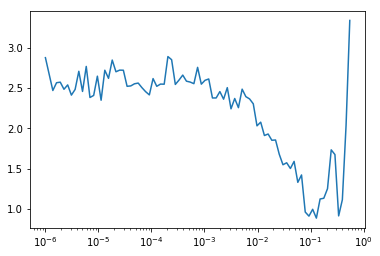

In [27]:
run.recorder.plot(skip_last=2)

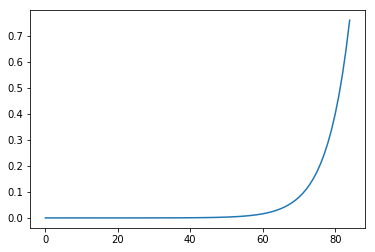

In [28]:
run.recorder.plot_lr()